# EBM: The Struggle to Learn the Two Moons

In [1]:
# Install only if needed
# Uncomment and run if libraries are missing
#!pip install torch matplotlib scikit-learn imageio==2.37.0 tqdm

In [2]:
# UNIVERSAL SETUP CELL
import os
import sys
from pathlib import Path

# Fix OpenMP issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def setup_imports():
    """Setup imports for both installed package and direct path access."""
    
    # Try package imports first
    try:
        from src.utils import get_data, plot_real_data
        from src.ebm import annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture
        from src.training import train_ebm_model
        from src.visualization import plot_energy_landscape_unified
        print("Package imports successful")
        return get_data, plot_real_data, annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture, train_ebm_model, plot_energy_landscape_unified
    except ImportError:
        pass
    
    # Try direct path imports
    try:
        # Add src to path if needed
        src_path = Path("src").resolve()
        if src_path.exists() and str(src_path) not in sys.path:
            sys.path.insert(0, str(src_path))
        
        from utils import get_data, plot_real_data
        from ebm import annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture
        from training import train_ebm_model
        from visualization import plot_energy_landscape_unified
        print("Direct imports successful")
        return get_data, plot_real_data, annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture, train_ebm_model, plot_energy_landscape_unified
    except ImportError:
        pass
    
    # Try parent directory
    try:
        src_path = Path("../src").resolve()
        if src_path.exists() and str(src_path) not in sys.path:
            sys.path.insert(0, str(src_path))
        
        from utils import get_data, plot_real_data
        from ebm import annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture
        from training import train_ebm_model
        from visualization import plot_energy_landscape_unified
        print("Direct imports successful")
        return get_data, plot_real_data, annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture, train_ebm_model, plot_energy_landscape_unified
    except ImportError:
        pass
    
    raise ImportError("Could not import required modules from src/")

# Setup imports
try:
    get_data, plot_real_data, annealed_langevin_sampler, EnergyModel, TGMixtureEnergy, sample_two_mixture, train_ebm_model, plot_energy_landscape_unified = setup_imports()
    print("All imports ready")
except Exception as e:
    print(f"Import setup failed: {e}")
    raise

# Test
try:
    x_real = get_data(100)
    print(f"Test successful: {x_real.shape}")
except Exception as e:
    print(f"Test failed: {e}")

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Direct imports successful
All imports ready
Test successful: torch.Size([100, 2])


In [3]:
# IMPORTS
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

# CONFIG
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seeds
torch.manual_seed(42)
np.random.seed(42)

# PLOT STYLE
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

figures_path = Path("../figures").resolve()
# create directory if it doesn't exist
figures_path.mkdir(parents=True, exist_ok=True)

## Introduction

Energy-Based Models (EBMs) are one of the most conceptually elegant ideas in machine learning:  
> Define a scalar energy function $ E(x) $ that assigns low values to plausible data, high values to implausible noise.  
> Then generate samples by letting a particle "roll downhill" via Langevin dynamics.

No need for a normalized probability.  
No need for an explicit generator.  
Just energy and noise.

This simplicity is seductive. It feels like physics: systems evolve toward low-energy states.  
And mathematically, it's grounded — the equilibrium distribution of Langevin dynamics is precisely $ p(x) \propto e^{-E(x)} $.

But there is a catch:  
> **Sampling requires exploring the entire landscape.**  
> And if the landscape has deep valleys separated by high ridges, the sampler gets stuck.

In this notebook, we test EBMs on the two-moons dataset — a simple distribution with two well-separated modes.  
We train with Contrastive Divergence and use annealed Langevin sampling.  
And despite reasonable hyperparameters and careful setup, the model fails to capture both modes.

The real question isn't *whether* it fails — it's **why**.  
Is it the architecture? The optimizer? The noise schedule?

Or is it something deeper — a fundamental limitation of local sampling in multi-modal spaces?

Spoiler: it's the last one.  
And recognizing that is what led to modern generative models like diffusion.

## The Dataset: Two Moons in $\mathbb{R}^2$

We work with the **two-moons dataset**, a classic benchmark consisting of two interlaced semicircular clusters in $\mathbb{R}^2$. Formally, it represents a mixture of two concentrated measures supported on disjoint, curved manifolds — a simple yet non-trivial structure that challenges generative modeling.

The key difficulty lies in the **topology**: the two modes are separated by a low-probability region. This creates a fundamental tension:
- A good model must avoid **mode collapse** (ignoring one mode)
- But also avoid **hallucinated bridges** (inventing connections)

In fact, many generative approaches struggle here:
- **GANs** often collapse to one mode
- **Flow-based models** may invent paths through low-density regions
- **Energy-Based Models**, as we will see, face a third problem: **poor mixing during sampling**

This makes two moons an ideal testbed: not because it's complex, but because it reveals deep issues in how models explore probability landscapes.

We generate $N = 1024$ points with additive noise $\epsilon = 0.1$:
```python
x, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
```

Then, we standardize the data:
$$
x \rightarrow \frac{x - \mu}{\sigma}
$$
 so that each coordinate has zero mean and unit variance - improving training stability.

In [4]:
# Generate and store data
data = get_data(n_samples=1024, normalize=True)
print(f"Data shape: {data.shape}")
print(f"Mean: {data.mean(dim=0)}")
print(f"Std:  {data.std(dim=0)}")

Data shape: torch.Size([1024, 2])
Mean: tensor([ 1.3039e-08, -1.6997e-08])
Std:  tensor([1., 1.])


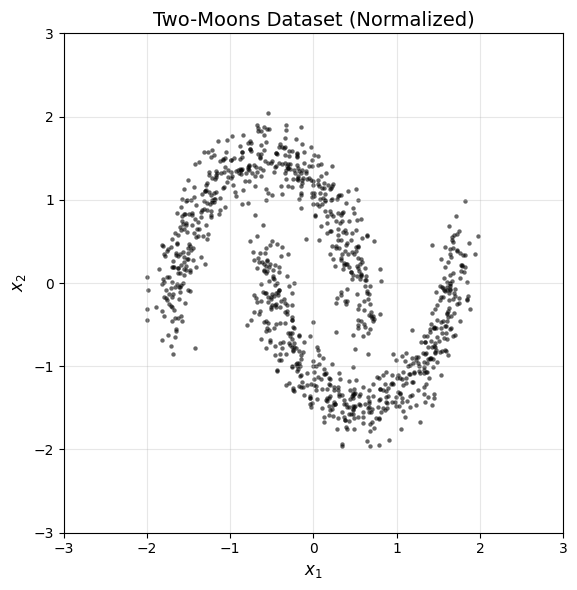

In [5]:
# Plot real data
plot_real_data(data, save_path=str(figures_path)+"/two_moons.png")

## Experiment 1: Random Models Have Structure

Even an untrained Energy-Based Model exhibits non-trivial structure in its energy landscape. The plots below show the energy $ E(x) $ of a randomly initialized neural network — no data has been seen, yet the function is far from flat.

Why? Because the composition of linear transformations and ReLU activations creates piecewise-linear boundaries, while random weights induce accidental symmetries and basins. These form **spurious valleys**: regions where $ E(x) $ is locally low, not due to data likelihood, but due to architectural priors.

This means the optimizer doesn't start from ignorance.  
It starts from **structured confusion** — and must *learn to erase* misleading patterns as much as it learns to represent real ones.

In this sense, training an EBM isn't just fitting a function.  
It's a battle between **data-driven learning** and **architecture-induced bias**.

/root/venv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


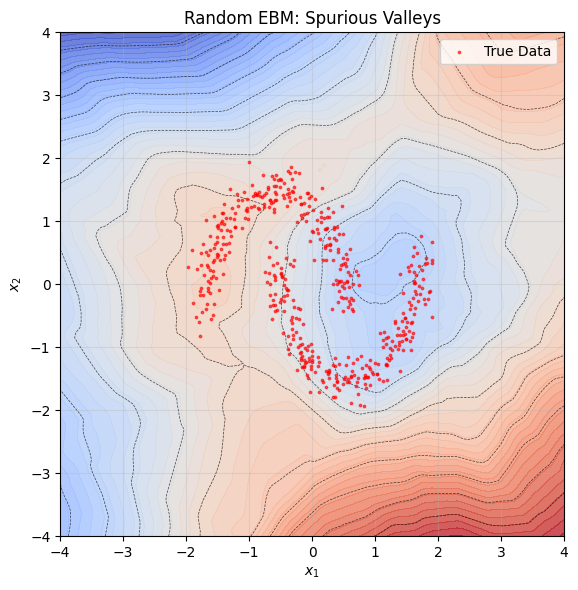

In [6]:
ebm = EnergyModel()

plot_energy_landscape_unified(
    ebm, 
    data=get_data(500),
    title="Random EBM: Spurious Valleys",
    style='both', 
    colormap='coolwarm'
)

### Experiment 2: MCMC Chains Get Stuck — Even With Perfect Energy

To isolate the problem, let's assume perfect knowledge.  
We define an energy function $ E(x) $ that corresponds exactly to the true data distribution: a mixture of two Gaussians centered at $(-2, 0)$ and $(2, 0)$.

This is not learned — it is hand-crafted. So there are no modeling errors.  


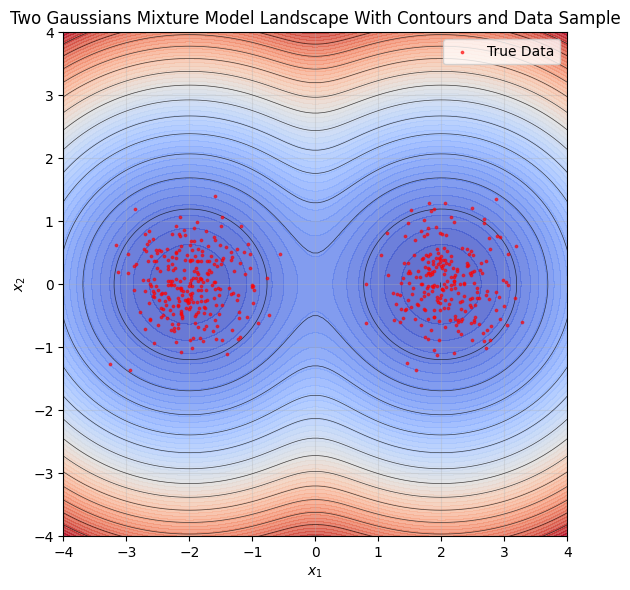

In [7]:
toy_model = TGMixtureEnergy()

plot_energy_landscape_unified(
    toy_model, 
    data=sample_two_mixture(500),
    title="Two Gaussians Mixture Model Landscape With Contours and Data Sample",
    style='both', 
    colormap='coolwarm'
)

And yet, when we sample using annealed Langevin dynamics, the chains fail to explore both modes equally.

Why? Because the **energy barrier** between the two Gaussians is high relative to the noise scale in the sampler.  
Even though both modes are equally likely, the probability of a chain crossing from one side to the other is exponentially small.

This is known as **metastability** or **slow mixing**: the Markov chain gets trapped in one basin, mistaking local equilibrium for global structure.

In [8]:
def plot_chain_trajectories(model, x_init, title="MCMC Chain Trajectories"):
    # Run sampler and get full trace
    trace = annealed_langevin_sampler(model, x_init, n_steps=300, burn_in=0, noise_scale=1.0)
    trace = trace.detach().cpu().numpy()  # [T, B, 2]

    plt.figure(figsize=(8, 6))
    
    # Plot trajectory of first 10 chains
    for i in range(min(10, trace.shape[1])):
        plt.plot(trace[:, i, 0], trace[:, i, 1], '-', alpha=0.6, linewidth=1)

    # Mark start and end
    plt.scatter(trace[0, :, 0], trace[0, :, 1], c='green', s=30, label='Start', zorder=5)
    plt.scatter(trace[-1, :, 0], trace[-1, :, 1], c='red', s=30, label='End', zorder=5)

    plt.scatter([-2, 2], [0, 0], c='black', s=100, marker='x', zorder=5, label='True Modes')

    plt.title(title)
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.legend()
    plt.xlim(-4, 4); plt.ylim(-4, 4)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    return trace

def has_crossed(x_traj, threshold=0.0):
    """Check if any particle crosses x1 = 0 during trajectory"""
    x1_traj = x_traj[:, :, 0]  # [T, B]
    signs = np.sign(x1_traj)
    crossings = np.diff(signs, axis=0)  # When sign changes
    return np.any(crossings != 0, axis=0) 


def first_crossing_time(trace, dim=0, threshold=0.0):
    """
    For each chain, find the first time it crosses x_dim = threshold.
    
    trace: [T, B, 2] tensor or numpy array
    Returns: (B,) array of integers (step index), with np.inf for never-crossed
    """
    # Convert to numpy
    x_traj = trace[:, :, dim]  # [T, B]
    
    # Compute sign before and after each step
    signs = np.sign(x_traj)
    # Handle zeros: treat as positive
    signs[signs == 0] = 1
    
    # Detect sign changes between consecutive steps
    diff_signs = np.diff(signs, axis=0)  # [T-1, B]
    crossings = (diff_signs != 0)  # [T-1, B]
    
    # Find the first crossing *time step* (in the original T indexing)
    # argmax finds the first True; if none, we'll set to inf
    crossing_steps = np.full(crossings.shape[1], np.inf)  # Initialize with inf
    
    for b in range(crossings.shape[1]):
        hit = np.where(crossings[:, b])[0]  # All crossing times for chain b
        if len(hit) > 0:
            crossing_steps[b] = hit[0] + 1  # Step in original trace (after diff)
    
    return crossing_steps  # float array with inf for no-crossing chains

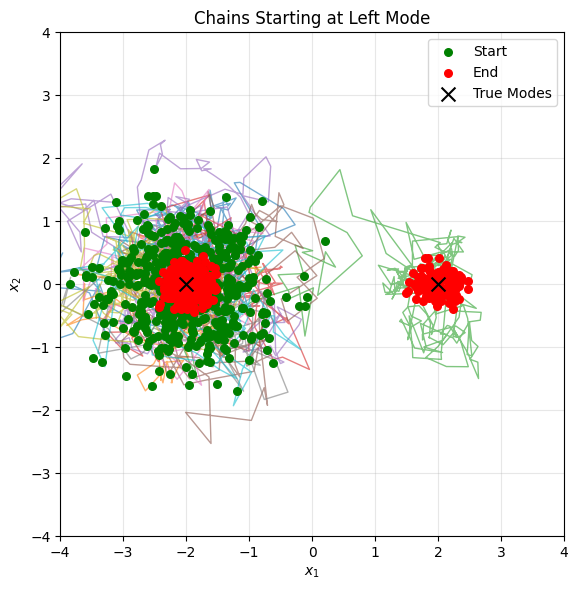

201 out of 500 chains crossed x_1=0


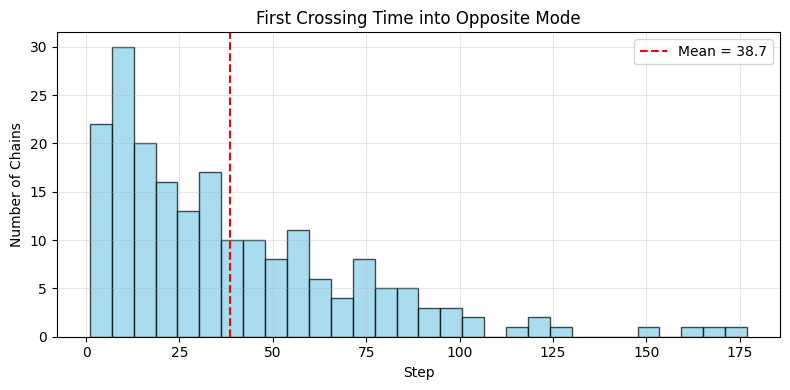

Average first crossing time: 38.7 steps
Chains that never crossed: 299


In [18]:
# Run single chain with full trace
# Many chains, all starting near left mode (-2, 0)
n_chains = 500
x_init_left = torch.randn(n_chains, 2) * 0.5 + torch.tensor([-2., 0.])

# Or right mode
x_init_right = torch.randn(n_chains, 2) * 0.5 + torch.tensor([2., 0.])

trace = plot_chain_trajectories(toy_model, x_init_left, "Chains Starting at Left Mode")
crossed = has_crossed(trace)
print(f"{crossed.sum()} out of {len(crossed)} chains crossed x_1=0")

# Compute crossing times
crossing_times = first_crossing_time(trace)  # Returns float array, inf for no-cross

# Histogram: only chains that crossed
valid_times = crossing_times[np.isfinite(crossing_times)]  # Filter out inf

plt.figure(figsize=(8, 4))
if len(valid_times) > 0:
    plt.hist(valid_times, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    mean_cross = valid_times.mean()
    plt.axvline(mean_cross, color='red', linestyle='--', label=f'Mean = {mean_cross:.1f}')
else:
    plt.text(0.5, 0.5, 'No chains crossed', transform=plt.gca().transAxes, 
             ha='center', va='center', fontsize=14, color='red')

plt.title("First Crossing Time into Opposite Mode")
plt.xlabel("Step")
plt.ylabel("Number of Chains")
plt.legend()
plt.tight_layout()
plt.show()

# Print stats
print(f"Average first crossing time: {valid_times.mean() if len(valid_times) > 0 else float('nan'):.1f} steps")
print(f"Chains that never crossed: {np.sum(np.isinf(crossing_times))}")

### Diagnosing Mixing: Not Stuck — Just Slow

Our experiment shows that less than half out of 500 chains crossed the $ x_1 = 0 $ boundary during 300 steps.  
This means the sampler is not completely trapped — some exploration occurs.

But consider:  
- True equilibrium requires **equal time spent in both modes**
- If only 42% of chains have crossed *at all*, many are still adjusting
- Chains that started on the left may not have reached statistical symmetry with those on the right

In fact, **mixing time** — the number of steps needed to "forget" the starting point — is likely much longer than 300.

This is the core issue:  
> Langevin dynamics doesn't fail catastrophically.  
> It fails subtly — by being too slow to matter.

And in deep learning, where we can't afford thousands of sampling steps per gradient update, **slow is indistinguishable from broken**.

### So What? Why Does This Matter?

In real applications:
- Data lives on complex, multi-modal manifolds (e.g., faces with different expressions)
- EBMs must capture all modes
- But if MCMC mixes slowly, the negative phase only sees part of the distribution

Then the model learns to lower energy **where it samples**, and raises it elsewhere — even if other modes are valid.

This leads to:
- **Mode collapse**: the model forgets under-sampled modes
- **Hallucinated bridges**: the sampler finds a low-energy path that doesn't exist
- **Poor generalization**: the model is shaped more by sampling bias than data

And no amount of training fixes this — because the problem is in the **inference**, not the representation.

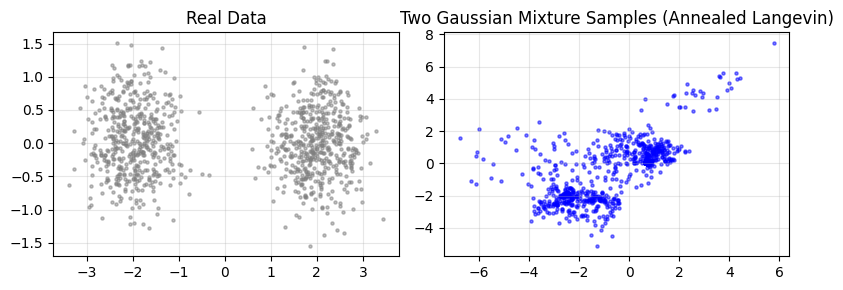

In [19]:
#Generate samples
true_samples = sample_two_mixture(1000).numpy()
x_energy_an = annealed_langevin_sampler(toy_model,  torch.randn(1000, 2)*2, n_steps=450, noise_scale=2.0, burn_in=50)
x_e = x_energy_an.detach().numpy()

# Plot
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.scatter(true_samples[:,0], true_samples[:,1], s=5, c='gray', alpha=0.5)
plt.title("Real Data")

plt.subplot(132)
plt.scatter(x_e[:,0], x_e[:,1], s=5, c='blue', alpha=0.5)
plt.title("Two Gaussian Mixture Samples (Annealed Langevin)")


plt.tight_layout()

> ❗ Training an EBM isn't just about designing a good energy function.  
> It's about ensuring the **sampling process explores fast enough** to provide meaningful gradients.

When mixing time > sampling budget, the model trains on **biased, incomplete information** — no matter how good the architecture or objective.

## Experiment 3: Contrastive Divergence — A Good Idea Trapped by Sampling

Contrastive Divergence (CD) is an elegant idea.  
It avoids the intractable partition function by approximating the gradient using short Markov chains:

$$
\nabla_\theta \mathcal{L} \approx \underbrace{\nabla_\theta E(x_{\text{real}})}_{\text{lower energy of data}} - \underbrace{\nabla_\theta E(x_{\text{fake}})}_{\text{raise energy of model samples}}
$$

In theory, as training progresses, the model learns to assign low energy to real data (all modes) and high energy everywhere else.

But there's a catch:  
> The negative phase relies on sampling from $ p_\theta(x) \propto e^{-E(x)} $ using Langevin dynamics — and we've just shown that **these chains don't mix in time**.

So while CD *wants* to lower energy on both moons, it only sees one side during training.

Starting EBM training on cpu...
Training EBM:   0%|          | 0/1000 [00:00<?, ?it/s]Step 0 | GP: 0.9460, scaled: 0.0473
Main loss: 0.0193
EBM Loss: 0.067, E_real: 0.082, E_fake: 0.062


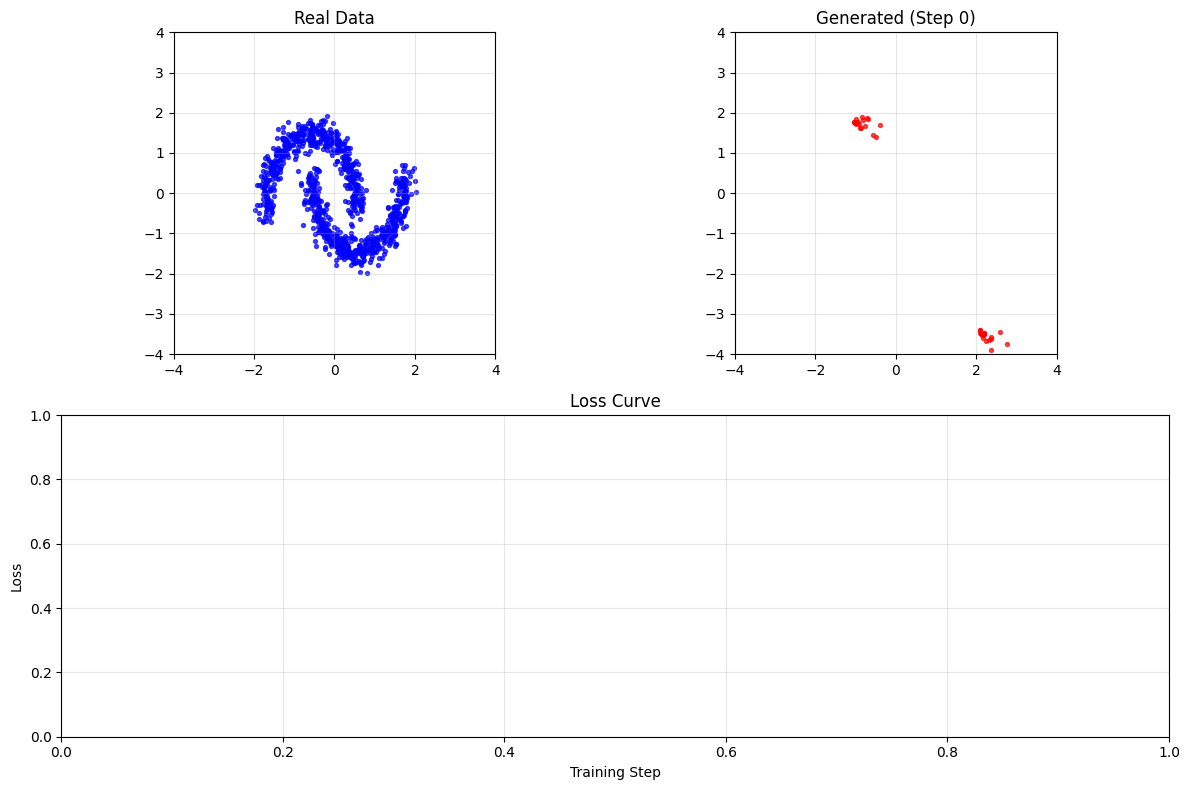

Training EBM:  10%|▉         | 99/1000 [00:13<02:12,  6.82it/s]Step 100 | GP: 0.8587, scaled: 0.0429
Main loss: -0.1290
EBM Loss: -0.086, E_real: 0.134, E_fake: 0.263


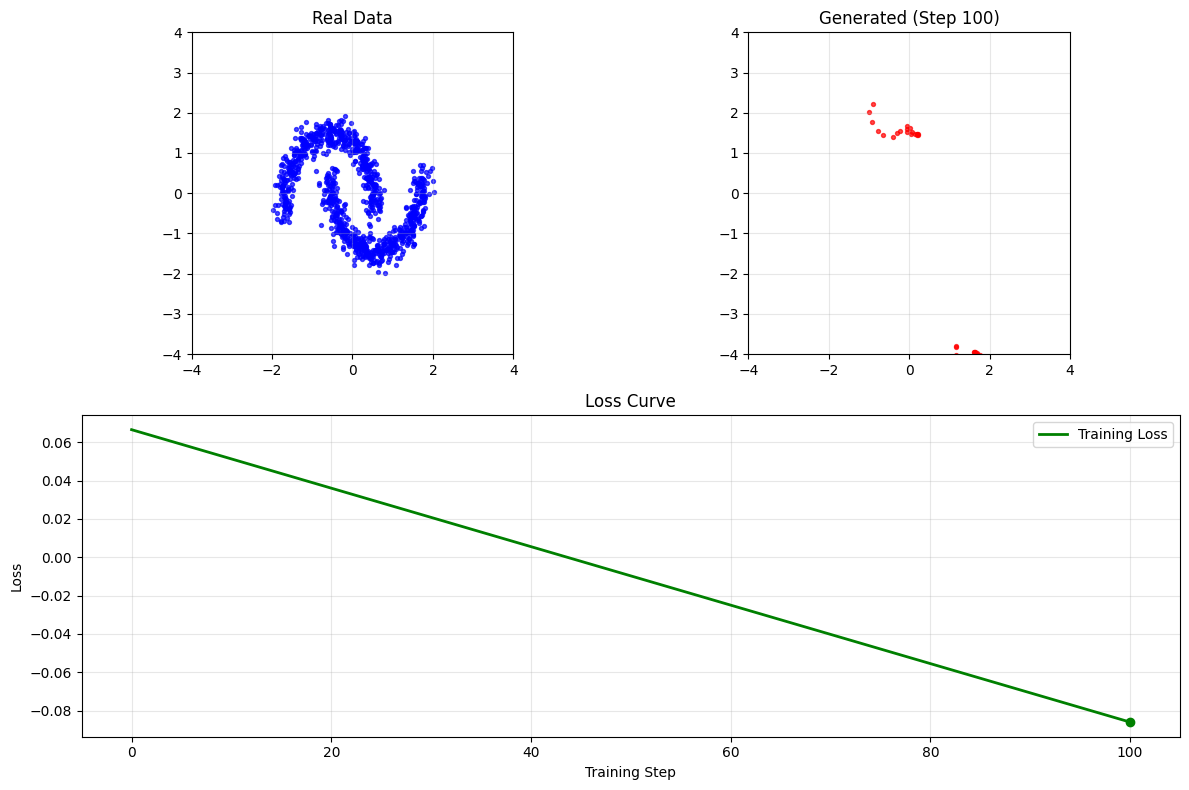

Training EBM:  20%|█▉        | 199/1000 [00:25<01:22,  9.68it/s]Step 200 | GP: 0.7098, scaled: 0.0355
Main loss: -0.2712
EBM Loss: -0.236, E_real: 0.236, E_fake: 0.507


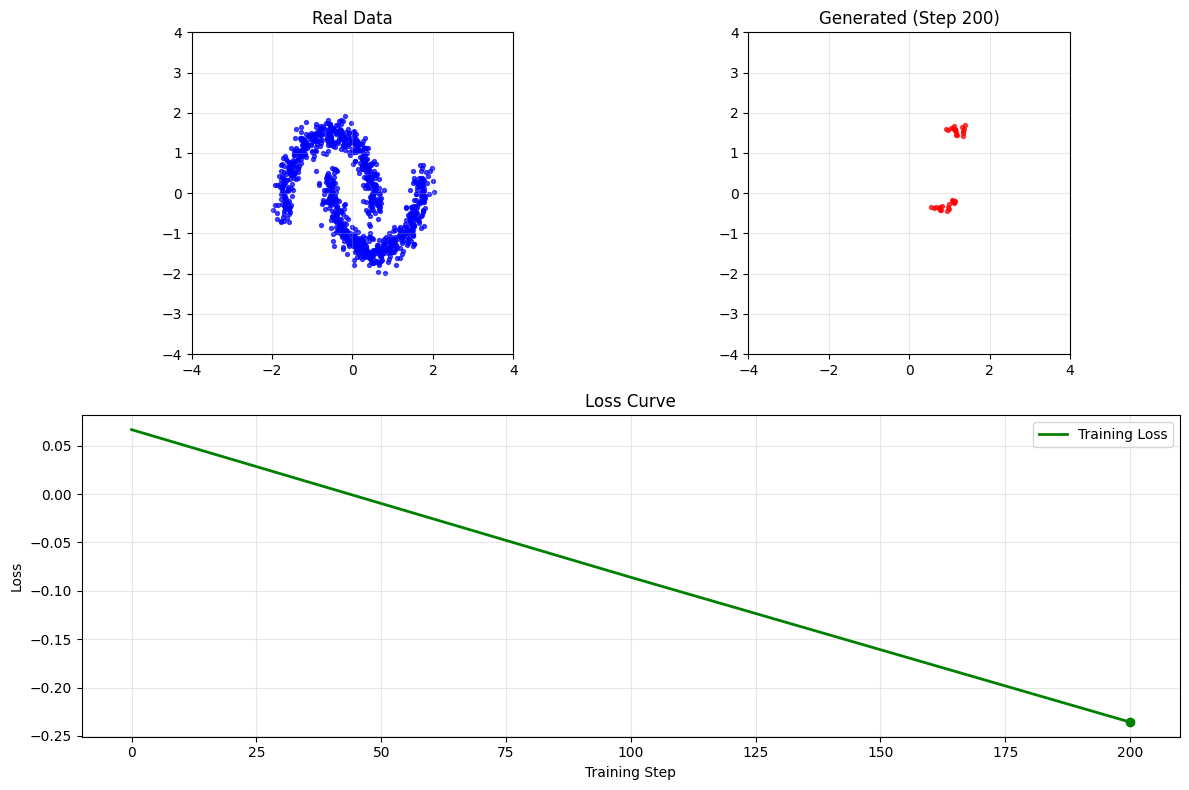

Training EBM:  30%|███       | 300/1000 [00:38<01:10,  9.93it/s]Step 300 | GP: 0.6021, scaled: 0.0301
Main loss: -0.3376
EBM Loss: -0.308, E_real: 0.332, E_fake: 0.670


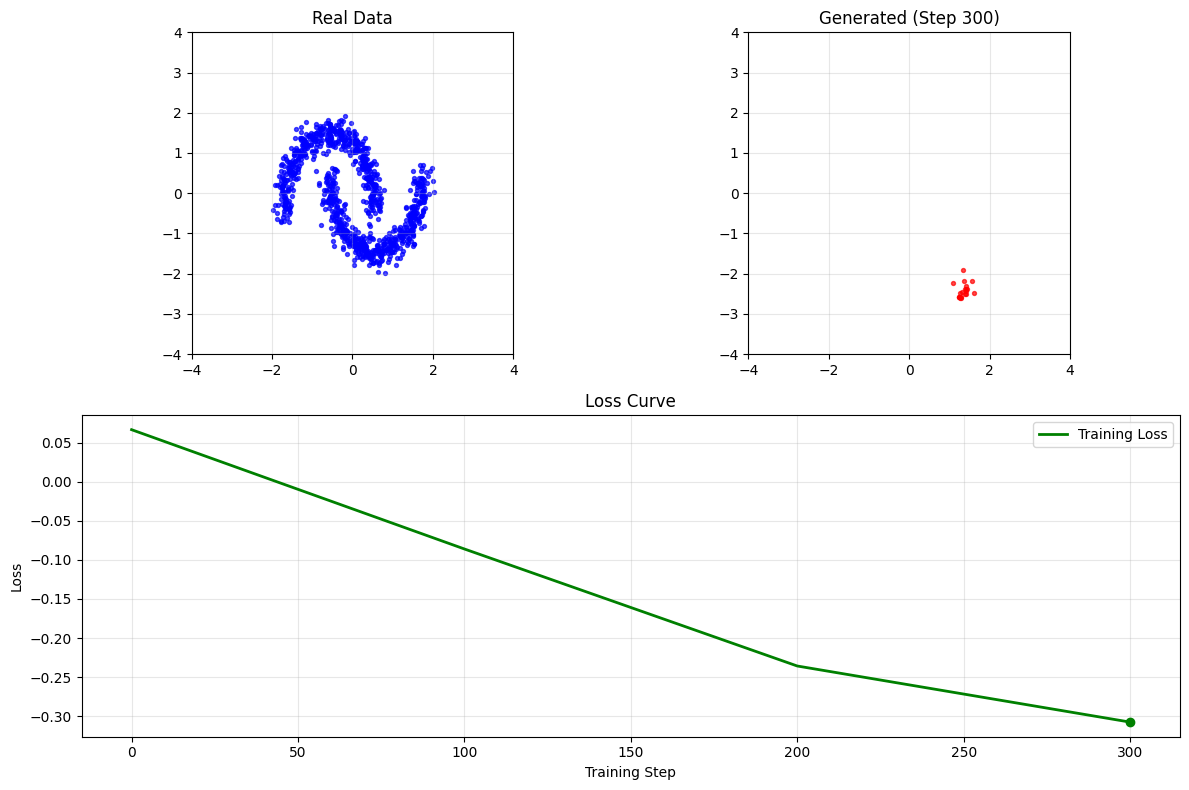

Training EBM:  40%|████      | 400/1000 [00:51<01:09,  8.65it/s]Step 400 | GP: 0.5284, scaled: 0.0264
Main loss: -0.4253
EBM Loss: -0.399, E_real: 0.438, E_fake: 0.864


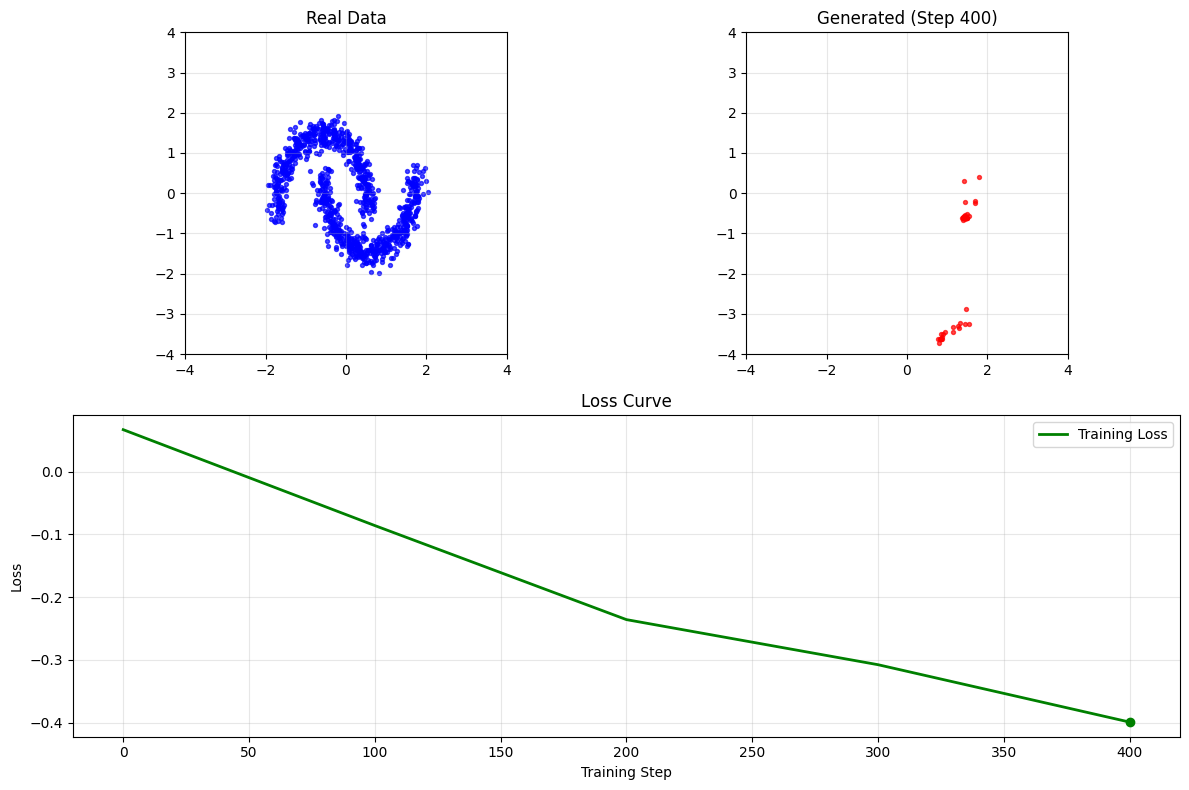

Training EBM:  50%|█████     | 500/1000 [01:05<00:53,  9.30it/s]Step 500 | GP: 0.4737, scaled: 0.0237
Main loss: -0.4515
EBM Loss: -0.428, E_real: 0.542, E_fake: 0.993


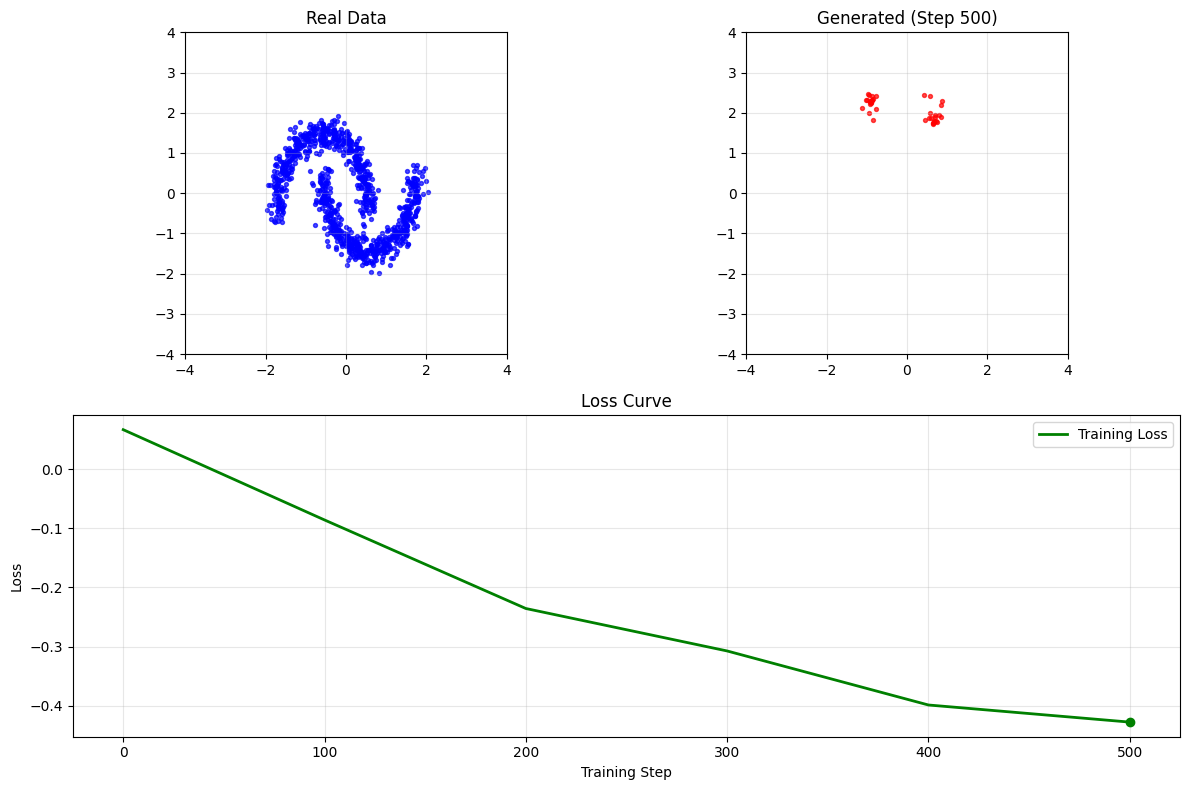

Training EBM:  60%|█████▉    | 599/1000 [01:17<00:42,  9.46it/s]Step 600 | GP: 0.4326, scaled: 0.0216
Main loss: -0.5078
EBM Loss: -0.486, E_real: 0.613, E_fake: 1.121


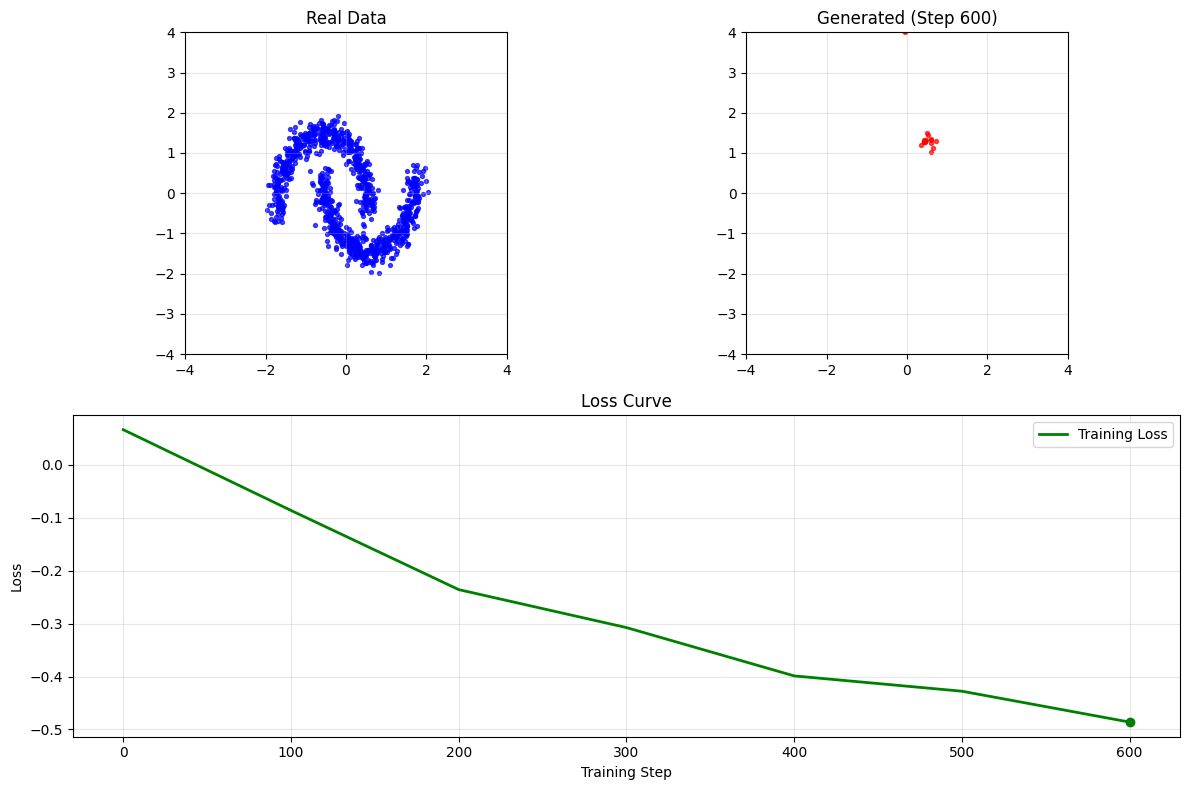

Training EBM:  70%|███████   | 700/1000 [01:29<00:32,  9.37it/s]Step 700 | GP: 0.4095, scaled: 0.0205
Main loss: -0.4366
EBM Loss: -0.416, E_real: 0.657, E_fake: 1.093


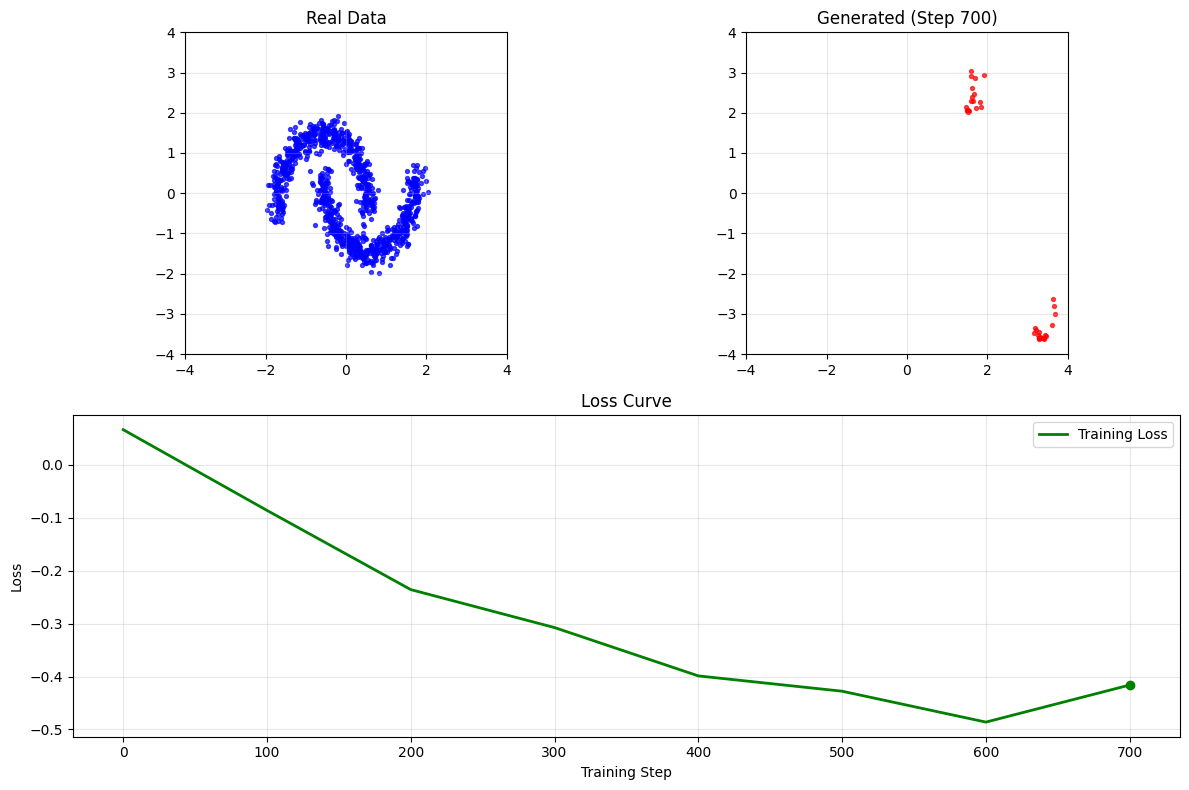

Training EBM:  80%|████████  | 800/1000 [01:42<00:19, 10.19it/s]Step 800 | GP: 0.3949, scaled: 0.0197
Main loss: -0.4911
EBM Loss: -0.471, E_real: 0.682, E_fake: 1.173


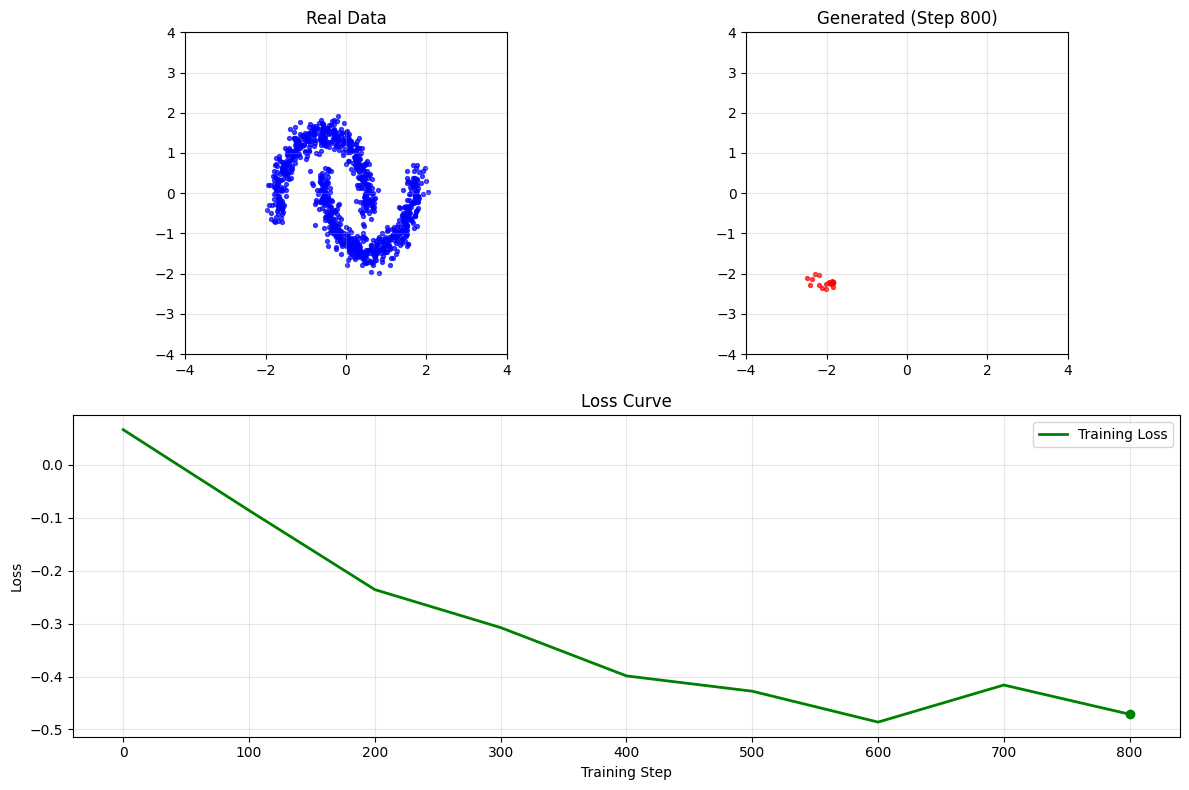

Training EBM:  90%|████████▉ | 899/1000 [01:53<00:09, 10.50it/s]Step 900 | GP: 0.3875, scaled: 0.0194
Main loss: -0.5369
EBM Loss: -0.518, E_real: 0.693, E_fake: 1.230


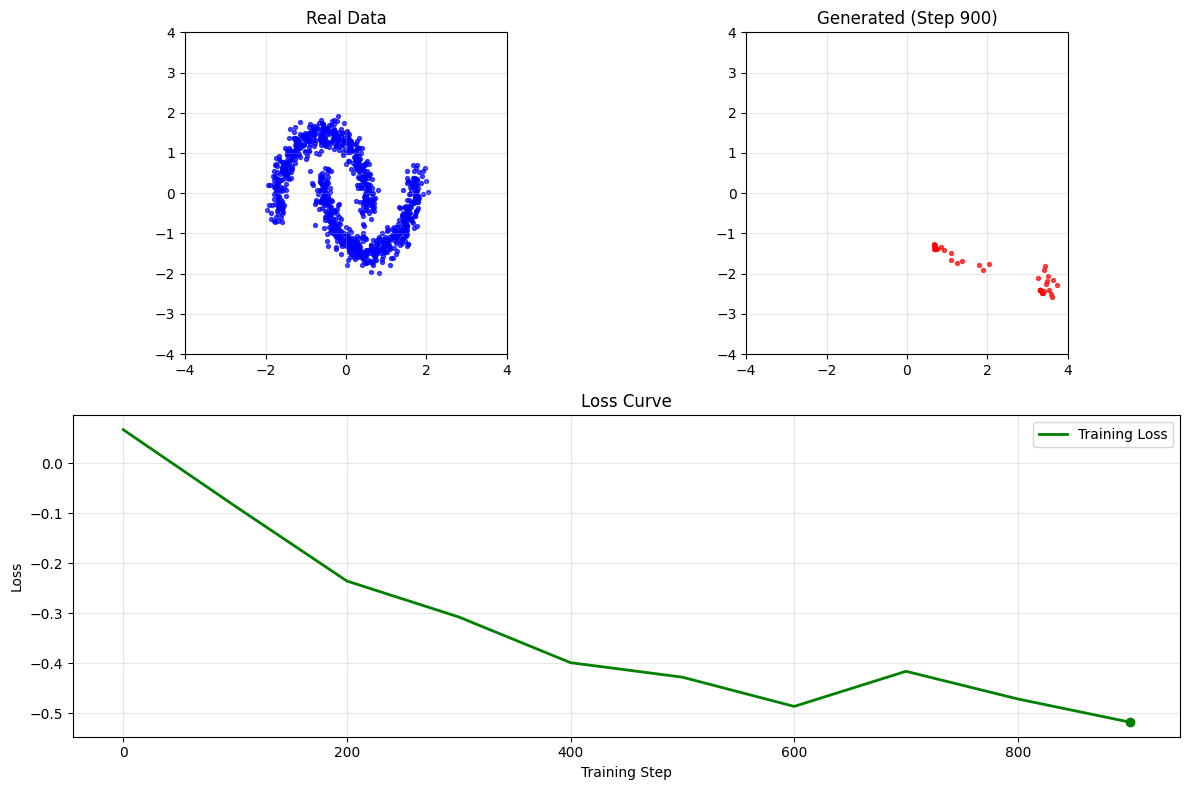

Training EBM: 100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


In [11]:
#EBM training 
model, history = train_ebm_model(
    n_epochs=1000,
    batch_size=256,
    learning_rate=1e-4,
    weight_decay=1e-4,
    lambda_gp=0.05,
    device='cpu',
    checkpoint_interval=100,
    visualize=True,
    figures_path="figures"
)

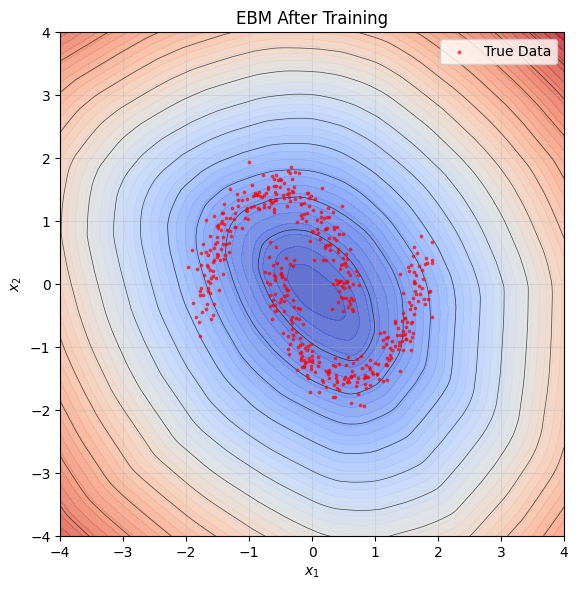

In [12]:
plot_energy_landscape_unified(model, data=get_data(500), title="EBM After Training", style='both', colormap='coolwarm')

## Results: The Failure

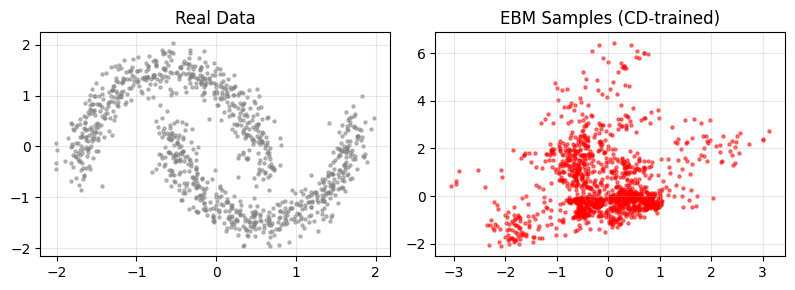

In [20]:
#Plot EBM vs real data

# Sample from EBM
x_ebm = annealed_langevin_sampler(model,  torch.randn(1000, 2)*2, n_steps=1000, noise_scale=1.0, burn_in=200)
x_e = x_ebm.detach().numpy()

# Plot
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.scatter(data[:,0], data[:,1], s=5, c='gray', alpha=0.5)
plt.title("Real Data")

plt.subplot(132)
plt.scatter(x_e[:,0], x_e[:,1], s=5, c='red', alpha=0.5)
plt.title("EBM Samples (CD-trained)")


plt.tight_layout()

### The Result: A Single Connected Valley

Despite the true distribution being bimodal, the trained EBM produces samples that form a **single connected cluster**.

Why? Because the negative phase begins with samples drawn from a broad distribution:  
$ x_{\text{fake}}^{(0)} \sim \mathcal{N}(0, 4I) $.  

Although the true data lies in two concentrated modes away from the origin, this initialization ensures diversity in the starting points. However, it also means that most chains begin in a low-density region — far from any meaningful structure.

Given that Langevin dynamics moves only locally, and that our sampling budget is limited to 30 steps, many chains fail to reach either mode during training. As a result, the model rarely observes samples from the full data manifold — especially across modes.

So the model learned:
- To lower energy near the two moons (positive phase)
- To raise energy along the path the sampler took — which was through the center

The result? A **spurious low-energy bridge** connecting the modes — not because the data suggests it, but because the **sampler couldn't explore properly**.

This is not overfitting.  
It is **sampling-induced bias**.
CD doesn't minimize energy on the data — it minimizes the gap between data and whatever the sampler reaches.
If the sampler is slow, the model adapts to its limitations.


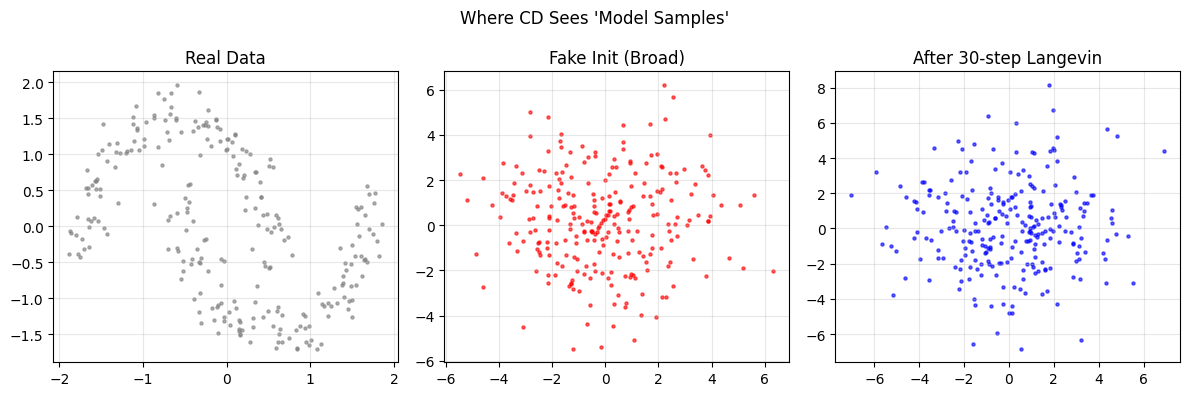

In [15]:
# One-step diagnostic
x_real = get_data(256)
x_fake_init = torch.randn(256, 2) * 2
x_fake = annealed_langevin_sampler(ebm, x_fake_init, n_steps=30, burn_in=10)[-1]

# Plot initialization vs final fake
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(x_real[:,0].numpy(), x_real[:,1].numpy(), s=5, c='gray', alpha=0.6)
plt.title("Real Data")

plt.subplot(132)
plt.scatter(x_fake_init[:,0].numpy(), x_fake_init[:,1].numpy(), s=5, c='red', alpha=0.6)
plt.title("Fake Init (Broad)")

plt.subplot(133)
plt.scatter(x_fake[:,0].numpy(), x_fake[:,1].numpy(), s=5, c='blue', alpha=0.6)
plt.title("After 30-step Langevin")

plt.suptitle("Where CD Sees 'Model Samples'")
plt.tight_layout()
plt.show()

To summarize:
1. CD tries to balance data and model samples.
2. But the model samples come from poorly mixed chains.
3. So the gradient only corrects energy along one path.
4. The model distorts the landscape to create artificial connections.
5. Conclusion: CD fails not due to theory — but due to **computational mismatch**.

### Epilogue: What Can We Do?

We could try:
- Longer chains → too slow
- Better samplers (HMC, tempering) → helps, but doesn’t scale
- Persistent CD → delays the problem

Or we could ask:  
> "What if we stopped relying on MCMC altogether?"

That’s exactly what **diffusion models** do — and that’s why they succeed where EBMs struggle.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de7d40e8-6998-4e65-8626-6720908f4576' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>